# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to ask: “do these datasets have similar patterns”?

To do this we will use a [procrustes analysis](https://en.wikipedia.org/wiki/Procrustes_analysis).

**How does it work?**
Given data1 and data2, procrustes manipulates data1 to transform it into data2 through a series of rotations, shifts, scaling in order to minimize the sum of squares of the difference between the two points: $\Sigma(data1 - data2)^2$.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import *
from scipy.spatial import procrustes
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Load config file
config_file = "config_exp_2.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

In [5]:
%%time
# Calculate disparity using Procrustes analysis
output_list = []

for i in num_batches:
    print('Cacluating disparity of 1 batch vs {} batches..'.format(i))
    
    # Get batch 1 data
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        index_col=0,
        sep='\t')

    # Simulated data with all samples in a single batch
    original_data_df =  batch_1
    
    # Get data with additional batch effects added
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    batch_data_df =  batch_other
    
    # Procrustes
    mtx1, mtx2, disparity = procrustes(original_data_df, batch_data_df)
    
    output_list.append(disparity)

Cacluating disparity of 1 batch vs 1 batches..
Cacluating disparity of 1 batch vs 2 batches..
Cacluating disparity of 1 batch vs 5 batches..
Cacluating disparity of 1 batch vs 10 batches..
Cacluating disparity of 1 batch vs 20 batches..
Cacluating disparity of 1 batch vs 50 batches..
Cacluating disparity of 1 batch vs 100 batches..
Cacluating disparity of 1 batch vs 500 batches..
Cacluating disparity of 1 batch vs 1000 batches..
Cacluating disparity of 1 batch vs 2000 batches..
Cacluating disparity of 1 batch vs 3000 batches..
Cacluating disparity of 1 batch vs 6000 batches..
CPU times: user 54min 4s, sys: 7min 29s, total: 1h 1min 33s
Wall time: 16min 54s


In [ ]:
# Permute simulated data
shuffled_simulated_arr = []
num_samples = batch_1.drop(['group']).shape[0]

for i in range(num_samples):
    row = list(batch_1.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, 
                                       index=batch_1.index,
                                       columns=batch_1.drop(['group']).columns)
shuffled_simulated_data.head()

In [ ]:
# Procrustes analysis of permuted dataset (Negative control)
mtx1, mtx2, permuted_disparity = procrustes(original_data_df, shuffled_simulated_data)

threshold = pd.DataFrame(
    pd.np.tile(
        permuted_disparity,
        (len(num_batches), 1)),
    index=num_batches,
    columns=['disparity'])

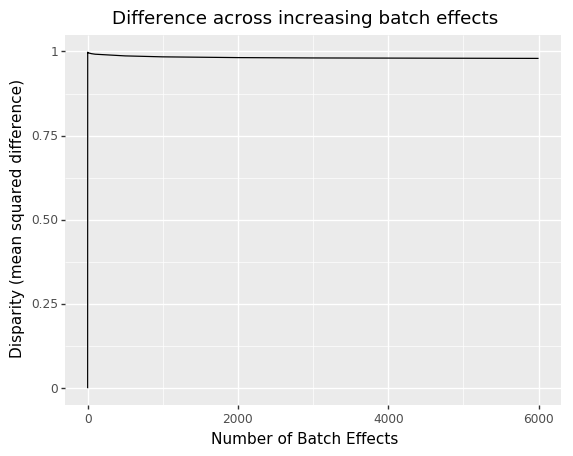

<ggplot: (8745904028669)>

In [7]:
# Plot
disparity_per_batch_effect = pd.DataFrame({'num_batch_effects':num_batches, 
                                     'disparity': output_list
                                    })

ggplot(disparity_per_batch_effect, aes(x='num_batch_effects', y='disparity')) \
    + geom_line() \
    + geom_line(aes(x=num_batches, y='disparity'), threshold, linetype='dashed') \
    + xlab('Number of Batch Effects') \
    + ylab('Disparity (mean squared difference)') \
    + ggtitle('Difference across increasing batch effects')